In [56]:
########################### Libraries ####################################
import astropy
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from astropy.coordinates.angle_utilities import hms_to_degrees, dms_to_degrees
from astropy.coordinates import SkyCoord  # High-level coordinates
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
import astropy.units as u
import re
import json
from collections import Counter
from operator import itemgetter
import scipy
from scipy.signal import argrelextrema
from astroML.time_series import lomb_scargle
from gatspy.periodic import LombScargleFast
from os import path
import matplotlib.backends.backend_pdf
import matplotlib.dates as mdates
import requests

In [57]:
#ОКПЗ

# We are storing url of dataset
# url = 'http://www.sai.msu.su/gcvs/gcvs/gcvs5/gcvs5.txt'
# # We are creating a requests variable with the above url
# r = requests.get(url, allow_redirects=True)
# # We are writing the content of above request to 'iris.data' file
# open('gcvs.txt', 'wb').write(r.content)

data = astropy.io.ascii.read('gcvs5.txt', data_start=2, delimiter='|',guess='txt')
data = data.to_pandas()
datalistt=data['Max'].tolist()
datalist=data['Min I'].tolist()

In [58]:
data.head()

,NNo,GCVS,J2000.0,Type,Max,Min I,Min II,Epoch,Year,Period,M-m,Spectrum,References,Other desig. p.m.(as/yr) Epoch Ident. New type GCVS
0,010001,R And *,002401.95 +383437.3,M,5.8,15.2,NaN,V |53820.,NaN,409.2,38,"S3,5e-S8,8e(M7e)",HIP 00002,|-0.016 -0.035|2000.0 | |Hip |M ...
1,010002,S And *,004243.1 +411605.0,SNI,5.8,< 16.,NaN,V |09775.,1885,NaN,NaN,(SNI),V 377 V 338,=M31 V0894| |1885.67 | |Lit. ...
2,010003,T And,002223.15 +265945.8,M,7.7,14.5,NaN,V |50854.,NaN,281.0,46,M4e-M7.5e,00001 00002,|-0.007 -0.003|2000.0 | |Tyc2 |M ...
3,010004,U And,011529.70 +404308.4,M,9.0,15.0,NaN,V |49564.,NaN,347.7,40,M6e,00001 00002,|+0.009 -0.011|2000.0 | |UCAC2 |M ...
4,010005,V And,005006.28 +353910.1,M,9.0,15.2,NaN,V |51528.,NaN,256.4,45,M2e-M3e,00001 00002,|-0.007 -0.007|2000.0 | |NPM |M ...


### GCVS input ('Max'  and 'Min I' columns) corrections

In [59]:
name=datalistt[39]# save strange nan?
for i in range(len(datalist)):
    try:
        if datalist[i][0]=='<':
            datalist[i]=datalist[i][2:]
        if datalist[i][-1]==':':
            datalist[i]=datalist[i][:4]
        if datalist[i][0]=='(':
            datalist[i]=100
    except:
        1==1
#         print(i)
        
for i in range(len(datalistt)):
    try:
        if datalistt[i]==datalistt[39]:
            datalistt[i]=0
        if datalistt[i][0]=='|':
            datalistt[i]=datalistt[1][1:]
    except:
        1==1
#         print(i)        

 # GCVS analyses  

### Here we remove stars which min mag< 12m

In [60]:
data['index']=data.index
i=0
k=0
index=[]
for i in range(len(datalist)):
    try:
        if float(datalist[i])<=10:
            index.append(i)
    except:
        print(1)
data=data.drop(index,axis=0)     
data=data.reset_index()        
data.shape

1
1


(48549, 16)

### Here we calculate the num of stars which max-min range does not fully belong to [12:20]

In [61]:
# k=0
# d=0
# for i in range(len(datalist)):
#     try:
#         if float(datalistt[i])<12:
#             d=d+1
# #             data=data.drop(index=i,axis=1)
#     except:
#         k=k+1
# print(d)
#18980

### result N of stars which belong to [12:20]

In [62]:
# data.shape[0]-d
#35999

In [63]:
# drop them
# data1=data1.drop(index=d,axis=1,inplace=True)
# data1=data1.reset_index()
# data1

### Take only necessary columns + coordinates preparation

In [64]:
# ОКПЗ
# data = astropy.io.ascii.read('gcvs5.txt', data_start=2, delimiter='|')

In [65]:
data = data[['J2000.0', 'Type','GCVS']]

In [66]:
# data = data.to_pandas()

In [67]:
data.Type = data.Type.map(lambda item: re.sub(':', '', str(item) ) if str(item).endswith(':') else str(item) )

In [68]:
data.rename(columns={'J2000.0':'coord'}, inplace=True)

In [69]:
data.drop(index=data[data.coord.map(lambda x: type(x) is not str )].index.values.tolist(), inplace=True)

In [70]:
data = data[ data.coord.map(lambda x: len(str(x)) == 19 ) ]

In [71]:
data['ra'] = data.coord.map(lambda x: x[:9])
data['dec'] = data.coord.map(lambda x: x[9:])

In [72]:
data.dec = data.dec.map(lambda x: x.replace(' ', '') )

In [73]:
data = data[ (data.dec.map(lambda x: x.startswith('+')) | data.dec.map(lambda x: x.startswith('-')) )
            & data.dec.map(lambda x: len(x) == 9 ) ]

In [74]:
data.reset_index(drop=True, inplace=True)

In [75]:
data.ra = data.ra.map(lambda x: hms_to_degrees(float(x[:2]), float(x[2:4]), float(x[4:])) )
data.dec = data.dec.map(lambda x: dms_to_degrees(float(x[:3]), float(x[3:5]), float(x[5:])))

In [76]:
#sorted(Counter(data.Type).items(), key=itemgetter(1), reverse=True)

## Features engineering (for ML)

In [77]:
data1=data[:2]# Для супербыстрой загрузки с сервера

In [78]:
# data1=data[42000:]

In [79]:
data1.iterrows()

<generator object DataFrame.iterrows at 0x00000262232E3F48>

In [80]:
rows = np.random.choice(data.index.values, 3000)
print(data1.shape)
data1.head()

(2, 5)


,coord,Type,GCVS,ra,dec
0,002401.95 +383437.3,M,R And *,6.008125,38.577028
1,004243.1 +411605.0,SNI,S And *,10.679583,41.268056


In [81]:
for i in range(data1.shape[0]):
    data1['ra'][i]=round(data1['ra'][i],3)

C:\Users\rtut6\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\rtut6\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3319: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


## Sending requests with different conditions and parameters + saving files

In [88]:
# # %%time
i=0
for item in data1.iterrows():
    resp = requests.get('http://db.ztf.snad.space/api/v1/circle/full/json?ra={ra}&dec={dec}&radius_arcsec={r}'.format(ra=item[1].ra, 
                                                                                                                      dec=item[1].dec, 
                                                                                                                      r=5)) 
    res = resp.json()
    print(res)
    i=i+1
    if len(res.keys())==1:
        with open(r"C:\Users\rtut6\Desktop\test\1"+str(i)+'.txt', 'w') as f:
            json.dump(res, f)
       
    if len(res.keys())==2:
        with open(r"C:\Users\rtut6\Desktop\test\2"+str(i)+'.txt', 'w') as f:
            json.dump(res, f) 
            
    if len(res.keys())==4:
        with open(r"C:\Users\rtut6\Desktop\test\4"+str(i)+'.txt', 'w') as f:
            json.dump(res, f)  
            
            
#         if i%1000==0:
#             print('11')

ConnectionError: HTTPConnectionPool(host='db.ztf.snad.space', port=80): Max retries exceeded with url: /api/v1/circle/full/json?ra=6.008&dec=38.57702777777778&radius_arcsec=5 (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000002622C892BE0>: Failed to establish a new connection: [WinError 10060] Попытка установить соединение была безуспешной, т.к. от другого компьютера за требуемое время не получен нужный отклик, или было разорвано уже установленное соединение из-за неверного отклика уже подключенного компьютера'))

### Viewing all the names in folder

### Fill names1 with files of first folder (1 id ) and names 2 with files of second folder (2 id) etc.

In [89]:
from os import walk
names1 = []
mypath1=r'C:\Users\rtut6\Desktop\Backup\1' # first (1) or second (2) folder
for (dirpath, dirnames, filenames) in walk(mypath1):
    names1.extend(filenames)
    break
names2 = []
mypath2=r'C:\Users\rtut6\Desktop\Backup\2' # first (1) or second (2) folder
for (dirpath, dirnames, filenames) in walk(mypath2):
    names2.extend(filenames)
    break 
names4 = []
mypath3=r'C:\Users\rtut6\Desktop\Backup\4' # first (1) or second (2) folder
for (dirpath, dirnames, filenames) in walk(mypath4):
    names4.extend(filenames)
    break
    
for i in range(len(names1)):
    try:
        names1[i]=names1[i][:-4]
    except:
        print('1')
        
for i in range(len(names2)):
    try:
        names2[i]=names2[i][:-4]
    except:
        print('1')
        
for i in range(len(names4)):
    try:
        names4[i]=names4[i][:-4]
    except:
        print('1')
 
# for i in range(len(f)):
#     if len(f[i])<13:
#         f.pop(i) 
# names1=f        

NameError: name 'mypath' is not defined

### id-distribution (numbers come from number of elements in folders

In [ ]:
# import plotly.express as px
# # my_data.head(20)
# import chart_studio.plotly as py
# import plotly.graph_objs as go

# values = '2.0 ID', '4.0 ID', '1.0 ID', '3.0 ID','6.0 ID'
# sizes = [12580, 1610, 5330, 273,48] # Размеры пяти самых больших классов

# trace = go.Pie(labels=labels, values=values)

# py.iplot([trace], filename='basic_pie_chart')


### Distribution for distances in GCVS-ZTF for answers with 1 ID, r=5arcsec

In [ ]:
# df = pd.read_csv(r'1IDobj.csv',sep='\t')
# df['dist1']=df['dist1']
# df['dist1'].hist(bins=100)
# plt.title ("Distribution for distances in GCVS-ZTF for answers with 1 ID, r=5arcsec") #данные по всему каталогу 

In [ ]:
# listl=[]
# for item in names2: 
#     with open(r"C:\Users\rtut6\Desktop\Backup\2\{}.txt".format(item)) as file:
#         res = file.read().replace("'", '"')
#     res=json.loads(res)
#     c1=SkyCoord(res[list(res.keys())[0]]['meta']['coord']['ra']*u.degree, res[list(res.keys())[0]]['meta']['coord']['dec']*u.degree)
#     c2=SkyCoord(res[list(res.keys())[1]]['meta']['coord']['ra']*u.degree, res[list(res.keys())[1]]['meta']['coord']['dec']*u.degree)
#     sep0 = c1.separation(c2)
#     listl.append(sep0.value)

In [ ]:
# with open('listl.csv', 'wb') as f:
#     pickle.dump(listl, f)

In [ ]:
# import pickle
# with open('listl.csv', 'rb') as f:
#     listl = pickle.load(f)

In [ ]:
# for i in range(len(listl)):
#     listl[i]=listl[i]*3600

### Distribution for distances in ZTF for answers with 2 id (between ids), r=1.5arcsec

In [ ]:
# df=pd.DataFrame(index=range(len(listl)),columns=['degr'])
# df['degr']=listl
# df.hist(bins=100)
# # np.cumsum(a)
# plt.title ("Distribution for distances in ZTF for answers with 2 id (between ids), r=1.5arcsec") #данные по всему каталогу 

# Homegenuous dataframes

### Create a DataFrame:

In [213]:
df=pd.DataFrame(columns=['ra','dec','Nobs','filter','Name'],index=range(35000))

In [90]:
def homogen(var_type,df):
    i=0
    for item in names1:
        with open(r"C:\Users\rtut6\Desktop\Backup\1\{}.txt".format(item)) as file: # 2 or 1 folder (replace to switch)
            res = file.read().replace("'", '"')
        res=json.loads(res)
    #     temp=0
        for i in res.keys():
            if res[list(res.keys())[i]]['meta']['filter']==var_type:
                df['ra'][i]=round(res[list(res.keys())[i]]['meta']['coord']['ra'],3)
                df['dec'][i]=res[list(res.keys())[i]]['meta']['coord']['dec']
                df['Nobs'][i]=res[list(res.keys())[i]]['meta']['nobs']
                df['filter'][i]=res[list(res.keys())[i]]['meta']['filter']
                df['Name'][i]=item
                i=i+1

    for item in names2:
        with open(r"C:\Users\rtut6\Desktop\Backup\2\{}.txt".format(item)) as file: # 2 or 1 folder (replace to switch)
            res = file.read().replace("'", '"')
        res=json.loads(res)
    #     temp=0
        for i in res.keys():
            if res[list(res.keys())[i]]['meta']['filter']==var_type:
                df['ra'][i]=round(res[list(res.keys())[i]]['meta']['coord']['ra'],3)
                df['dec'][i]=res[list(res.keys())[i]]['meta']['coord']['dec']
                df['Nobs'][i]=res[list(res.keys())[i]]['meta']['nobs']
                df['filter'][i]=res[list(res.keys())[i]]['meta']['filter']
                df['Name'][i]=item
                i=i+1
                
    for item in names4:
        with open(r"C:\Users\rtut6\Desktop\Backup\4\{}.txt".format(item)) as file: # 2 or 1 folder (replace to switch)
            res = file.read().replace("'", '"')
        res=json.loads(res)
    #     temp=0
        for i in res.keys():
            if res[list(res.keys())[i]]['meta']['filter']==var_type:
                df['ra'][i]=round(res[list(res.keys())[i]]['meta']['coord']['ra'],3)
                df['dec'][i]=res[list(res.keys())[i]]['meta']['coord']['dec']
                df['Nobs'][i]=res[list(res.keys())[i]]['meta']['nobs']
                df['filter'][i]=res[list(res.keys())[i]]['meta']['filter']
                df['Name'][i]=item
                i=i+1
    df1=df.merge(data1, left_on=['ra'], right_on=['ra'])
    index=[]
    for i in range(df1.shape[0]):
        if abs(df1['dec_x'][i]-df11['dec_y'][i])>=0.0005:
            index.append(i)
    df1=df1.drop(index,axis=0)
    df1 = df1.reset_index(drop=True)
    df1=df11.drop(['Unnamed: 0','dec_y'],axis=1)
    df1.to_csv("homogen" + var_type+ ".csv", sep='\t')           

In [91]:
def homogen_summ(df,hold,data1):
    i=0
    types=['zg','zr']
    for item in names2:
        with open(r"C:\Users\rtut6\Desktop\Backup\2\{}.txt".format(item)) as file: # 2 or 1 folder (replace to switch)
            res = file.read().replace("'", '"')
        res=json.loads(res)
        
        if min(res[list(res.keys())[0]]['meta']['nobs'],res[list(res.keys())[1]]['meta']['nobs'])>hold:
            for i in res.keys():                 
                df['ra'][i]=round(res[list(res.keys())[i]]['meta']['coord']['ra'],3)
                df['dec'][i]=res[list(res.keys())[i]]['meta']['coord']['dec']
                df['Nobs'][i]=res[list(res.keys())[i]]['meta']['nobs']
                df['filter'][i]=res[list(res.keys())[i]]['meta']['filter']
                df['Name'][i]=item
                i=i+1
                
    for item in names4:
        with open(r"C:\Users\rtut6\Desktop\Backup\4\{}.txt".format(item)) as file: # 2 or 1 folder (replace to switch)
            res = file.read().replace("'", '"')
        res=json.loads(res)
        zg=[]
        zr=[]
        for i in res.keys():
            if res[list(res.keys())[i]]['meta']['filter']=='zg':
                zg.append(res[list(res.keys())[i]]['meta']['nobs'])
            if res[list(res.keys())[i]]['meta']['filter']=='zr':
                zr.append(res[list(res.keys())[i]]['meta']['nobs'])
            if min(max(zg),max(zr))>hold:
                df['ra'][i]=round(res[list(res.keys())[i]]['meta']['coord']['ra'],3)
                df['dec'][i]=res[list(res.keys())[i]]['meta']['coord']['dec']
                df['Nobs'][i]=res[list(res.keys())[i]]['meta']['nobs']
                df['filter'][i]=res[list(res.keys())[i]]['meta']['filter']
                df['Name'][i]=item
                i=i+1        
    df1=df.merge(data1, left_on=['ra'], right_on=['ra'])
    index=[]
    for i in range(df1.shape[0]):
        if abs(df1['dec_x'][i]-df11['dec_y'][i])>=0.0005:
            index.append(i)
    df1=df1.drop(index,axis=0)
    df1 = df1.reset_index(drop=True)
    df1=df11.drop(['Unnamed: 0','dec_y'],axis=1)
    df1.to_csv("homogen_summ_example.csv", sep='\t')

### Each new row - one single observation (for each 2-id object we get 2 rows)

### Next we want to match coordinates of an object with its type of variability

### Here some problems with merging initial dataframe (data1) with new one (df)

In [ ]:
# df[df['ra']==290.22]

In [ ]:
# data1[data1['ra']==290.22]

### With "merge" function we'll have all possible combinations of ra from data1 and df (if they are the same). Here -18 rows. Because of that we have to filter rows of our dataframe by dec in data1 and df

### V types from GCVS:

In [232]:
eruptive=['FU', 'GCAS', 'I', 'IA', 'IB', 'IN', 'INA', 'INB', 'INT', 'IT', 'IN(YY)', 'IS', 'ISA',
          'ISB', 'RCB', 'RS', 'SDOR', 'UV', 'UVN', 'WR']
pulsating=['ACYG', 'BCEP', 'BCEPS', 'CEP', 'CEP(B)', 'CW', 'CWA', 'CWB', 'DCEP', 'DCEPS',
           'DSCT', 'DSCTC', 'GDOR', 'L', 'LB', 'LC', 'M', 'PVTEL', 'RPHS', 'RR', 'RR(B)', 'RRAB',
           'RRC', 'RV', 'RVA', 'RVB', 'SR', 'SRA', 'SRB', 'SRC', 'SRD', 'SXPHE', 'ZZ', 'ZZA', 'ZZB']
rotating=['ACV', 'ACVO', 'BY', 'ELL', 'FKCOM', 'PSR', 'SXARI']
cataclysmic=['N', 'NA', 'NB', 'NC', 'NL', 'NR','SN', 'SNI', 'SNII', 'UG', 'UGSS', 'UGSU', 'UGZ', 'ZAND']
eclipsing=['E', 'EA', 'EB', 'EW', 'GS', 'PN', 'RS', 'WD', 'WR', 'AR', 'D', 'DM','DS', 'DW', 'K', 'KE', 'KW', 'SD']
intense=['X', 'XB', 'XF', 'XI', 'XJ', 'XND', 'XNG', 'XP', 'XPR','XPRM', 'XM']
other=['BLLAC', 'CST', 'GAL', 'L:', 'QSO', 'S', '*', '+', ':','ZZO', 'AM', 'R', 'BE', 'LBV', 'BLBOO', 'EP', 'SRS', 'LPB']

### Make a new column ('Num') with class of variability

In [233]:
# #Numerate classes
df1['Num']=0
for i in range(df1.shape[0]):
    if df1['Type'][i] in eruptive:
        df1['Num'][i]=0
        continue
    if df1['Type'][i] in pulsating:
        df1['Num'][i]=1
        continue
    if df1['Type'][i] in rotating:
        df1['Num'][i]=2
        continue
    if df1['Type'][i] in cataclysmic:
        df1['Num'][i]=3
        continue
    if df1['Type'][i] in eclipsing:
        df1['Num'][i]=4
        continue
    if df1['Type'][i] in intense:
        df1['Num'][i]=5
    else:
        df1['Num'][i]=6

C:\Users\rtut6\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\rtut6\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\rtut6\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\rtut6\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value

### Look at names of files in pulsating type:

In [ ]:
# df1[df1['Num']==1]['Name'].tolist()

In [ ]:
df12=pd.read_csv('df1.csv', sep='\t')

In [ ]:
frames = [df1, df12]
df2=pd.concat(frames)

In [ ]:
df1=df2

### Calculate the numb of objects with Nobs> ... for each class

In [225]:
Nobs=pd.DataFrame(columns=['Type','N30','N50','N70'])

In [226]:
names=df1['Type'].value_counts()[:50].index.tolist()

In [227]:
Nobs=Nobs.drop('Type',axis=1)

In [228]:
indexk=[]
indexl=[]
indexm=[]
for item in names:
    k=0
    l=0
    m=0
    Frame=df1[df1['Type']==item]
    for i in range(len(Frame['Nobs'])):
        if Frame['Nobs'].tolist()[i]>30:
            k=k+1
        if Frame['Nobs'].tolist()[i]>50:
            l=l+1
        if Frame['Nobs'].tolist()[i]>70:
            m=m+1    
    indexk.append(k)
    indexl.append(l)
    indexm.append(m)
#     print(item,'k=',k)    
Nobs['N30']=indexk
Nobs['N50']=indexl
Nobs['N70']=indexm

In [540]:
df1=pd.read_csv('df1_homogen_zg.csv')
df2=pd.read_csv('df1_homogen_zr.csv')
df3=pd.read_csv('df1_homogen_summ.csv')

In [370]:
FrameX=pd.DataFrame(columns=['index','values'])
FrameX['index']=df1['Nobs'].value_counts()[:100].index
FrameX['values']=df1['Nobs'].value_counts()[:100].values
FrameX=FrameX.sort_values('index')
FrameX=FrameX.reset_index()   
FrameX=FrameX.drop('level_0',axis=1)

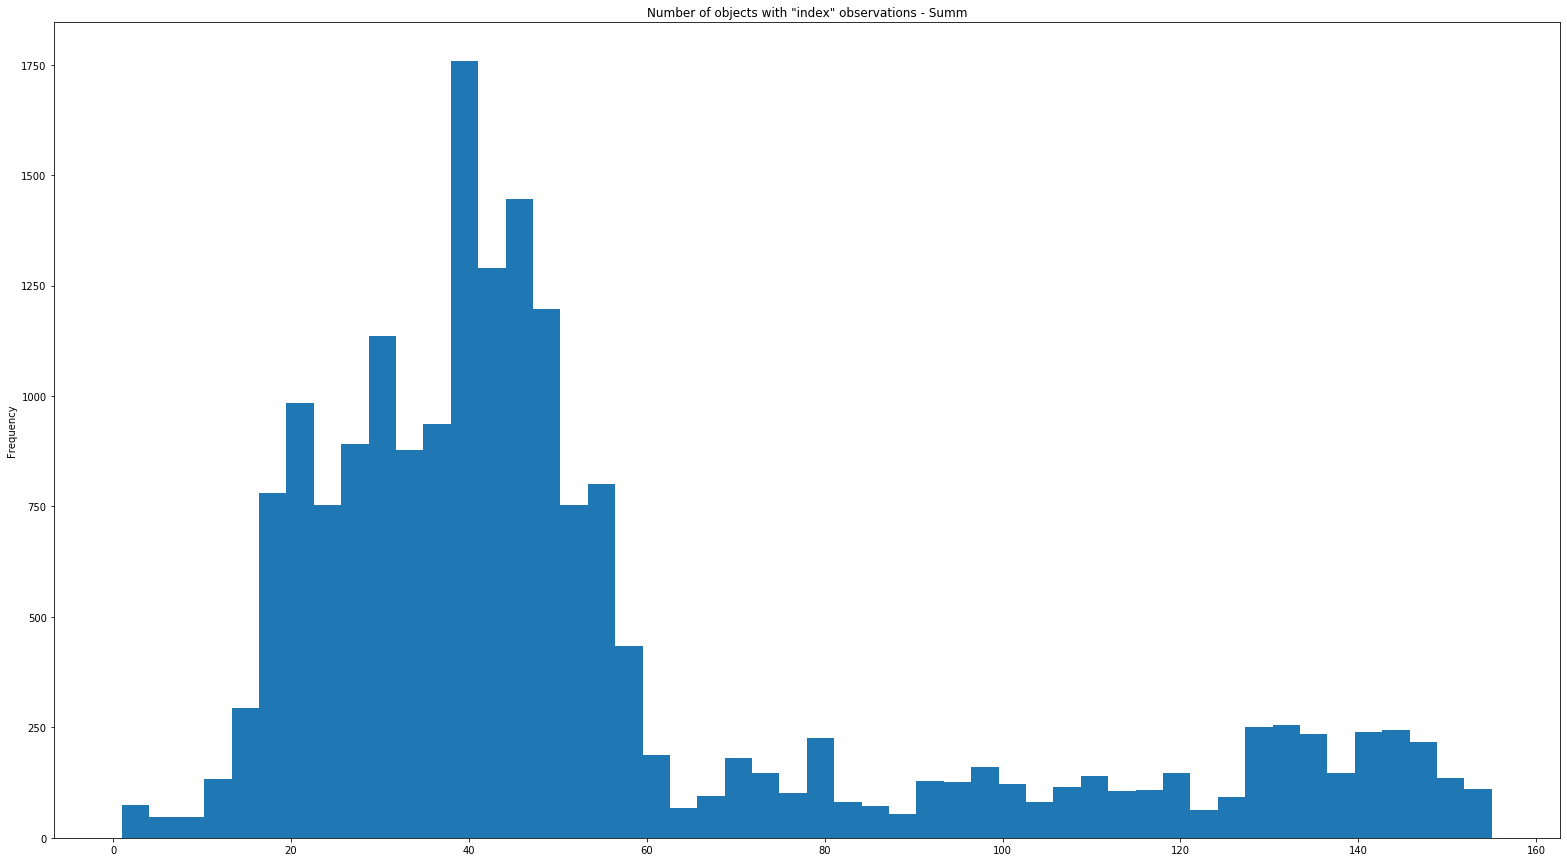

In [574]:
df1['Nobs'].plot(x='Nobs',kind='hist',figsize=(27,15),title='Number of objects with "index" observations - Summ',bins=50)

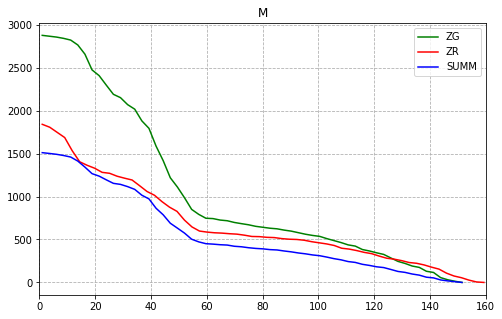

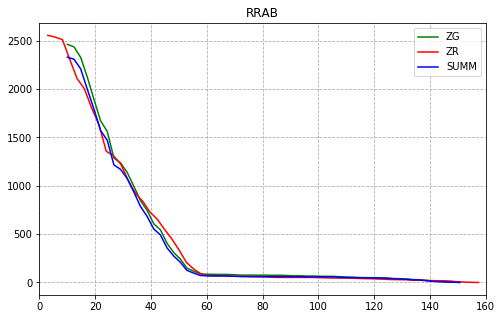

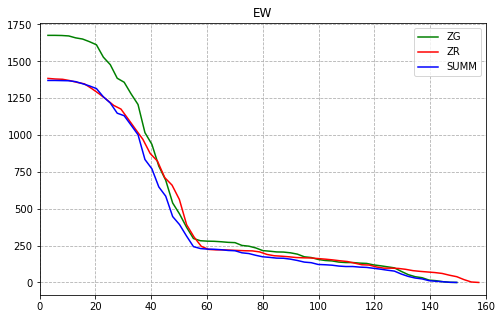

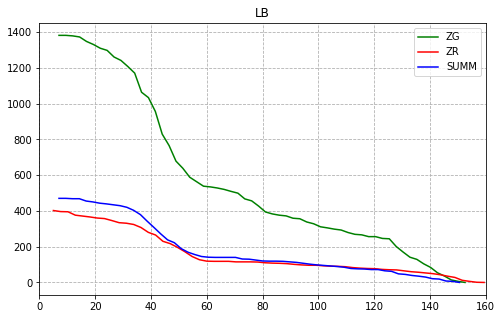

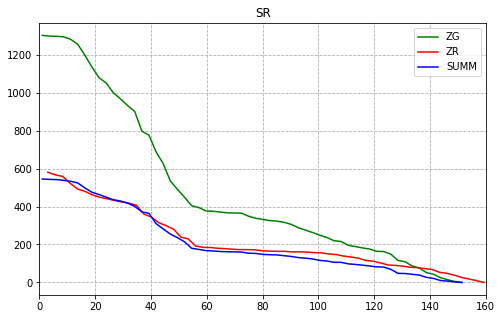

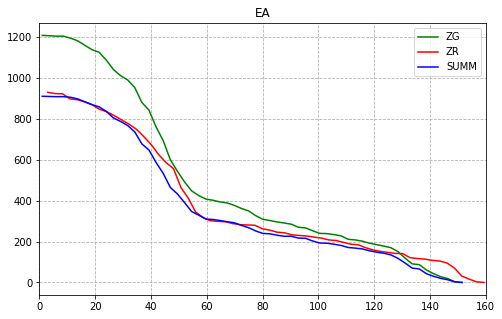

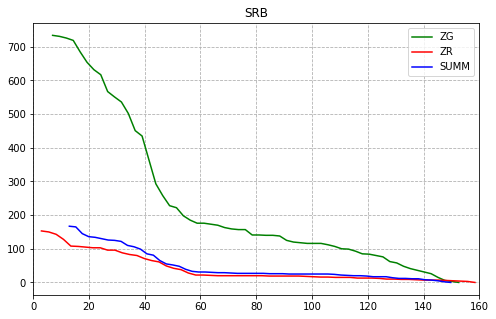

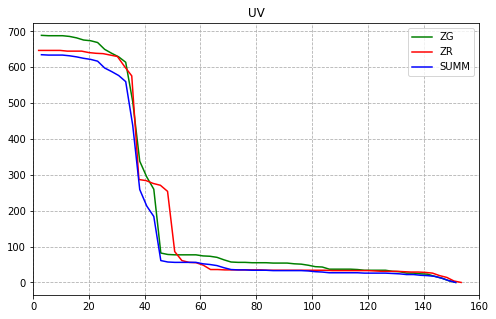

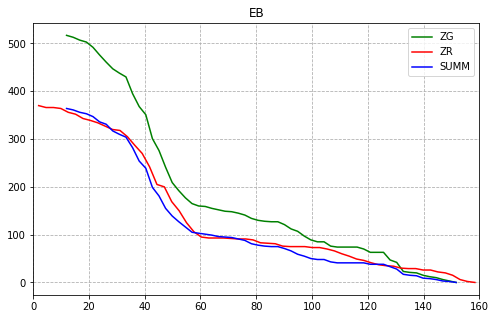

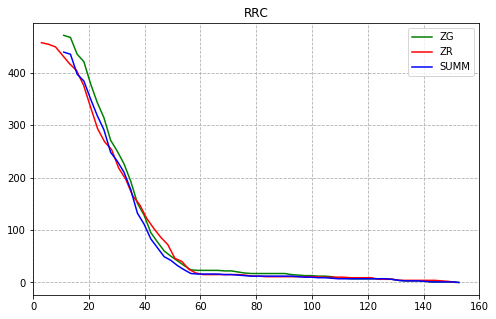

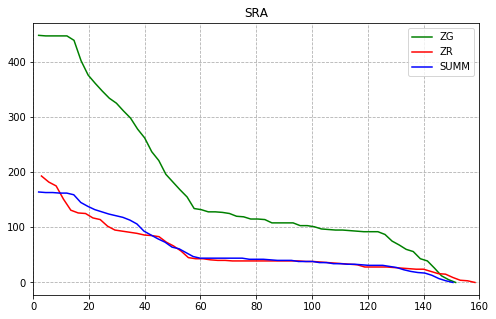

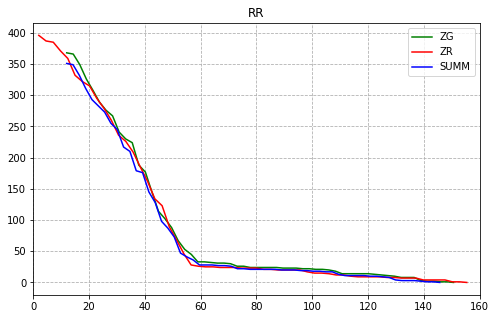

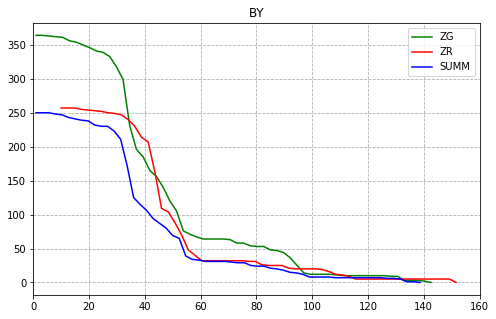

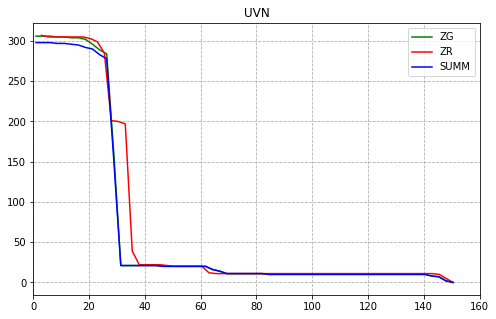

FileNotFoundError: [Errno 2] No such file or directory: 'EA/SD.pdf'

In [575]:
# some fake data
# data1 = df1['Nobs'].tolist()
# data2 = df2['Nobs'].tolist()
# data3 = df3['Nobs'].tolist()



# evaluate the histogram
# values1, base1 = np.histogram(data1, bins=60)
# values2, base2 = np.histogram(data2, bins=60)
# values3, base3 = np.histogram(data3, bins=60)
# #evaluate the cumulative
# cumulative1 = np.cumsum(values1)
# cumulative2 = np.cumsum(values2)
# cumulative3 = np.cumsum(values3)
# plt.plot(base1[:-1], len(data1)-cumulative1, c='green')
# plt.plot(base2[:-1], len(data2)-cumulative2, c='red')
# plt.plot(base3[:-1], len(data3)-cumulative3, c='blue',)
# plt.legend(['ZG','ZR','SUMM'])


names=df1['Type'].value_counts()[:100].index.tolist()

for item in names:
    
    pdf = matplotlib.backends.backend_pdf.PdfPages(item+".pdf")
    data1=df1[df1['Type']==item]['Nobs'].tolist()
    data2=df2[df2['Type']==item]['Nobs'].tolist()
    data3=df3[df3['Type']==item]['Nobs'].tolist()
    
    
    values1, base1 = np.histogram(data1, bins=60)
    values2, base2 = np.histogram(data2, bins=60)
    values3, base3 = np.histogram(data3, bins=60)
    
    
    
    cumulative1 = np.cumsum(values1)
    cumulative2 = np.cumsum(values2)
    cumulative3 = np.cumsum(values3)
    
    f=plt.figure(figsize=(8,5))
    plt.gca().set_xlim([0,160])
    ax.set_ylim([0,2500])
    ax = plt.gca()
    ax.set_facecolor((1.0, 1, 1))
    plt.plot(base1[:-1], len(data1)-cumulative1, c='green')
    plt.plot(base2[:-1], len(data2)-cumulative2, c='red')
    plt.plot(base3[:-1], len(data3)-cumulative3, c='blue',)
    plt.legend(['ZG','ZR','SUMM'])
    plt.title(item)
    plt.grid(True,linestyle="--")
    pdf.savefig(f) #saving pdf
    plt.show()
    
pdf.close()



# for item in names:
#     data=df1[df1['Type']==item]['Nobs'].tolist()
#     plt.plot(base1[:-1], len(data1)-cumulative1, c='green')
#     values, base = np.histogram(data, bins=60)
#     plt.plot(base[:-1], len(data)-cumulative, c='green')

# plt.legend(['ZG','ZR','SUMM'])

# plt.grid(True)
# plt.title(name)
# plt.show()

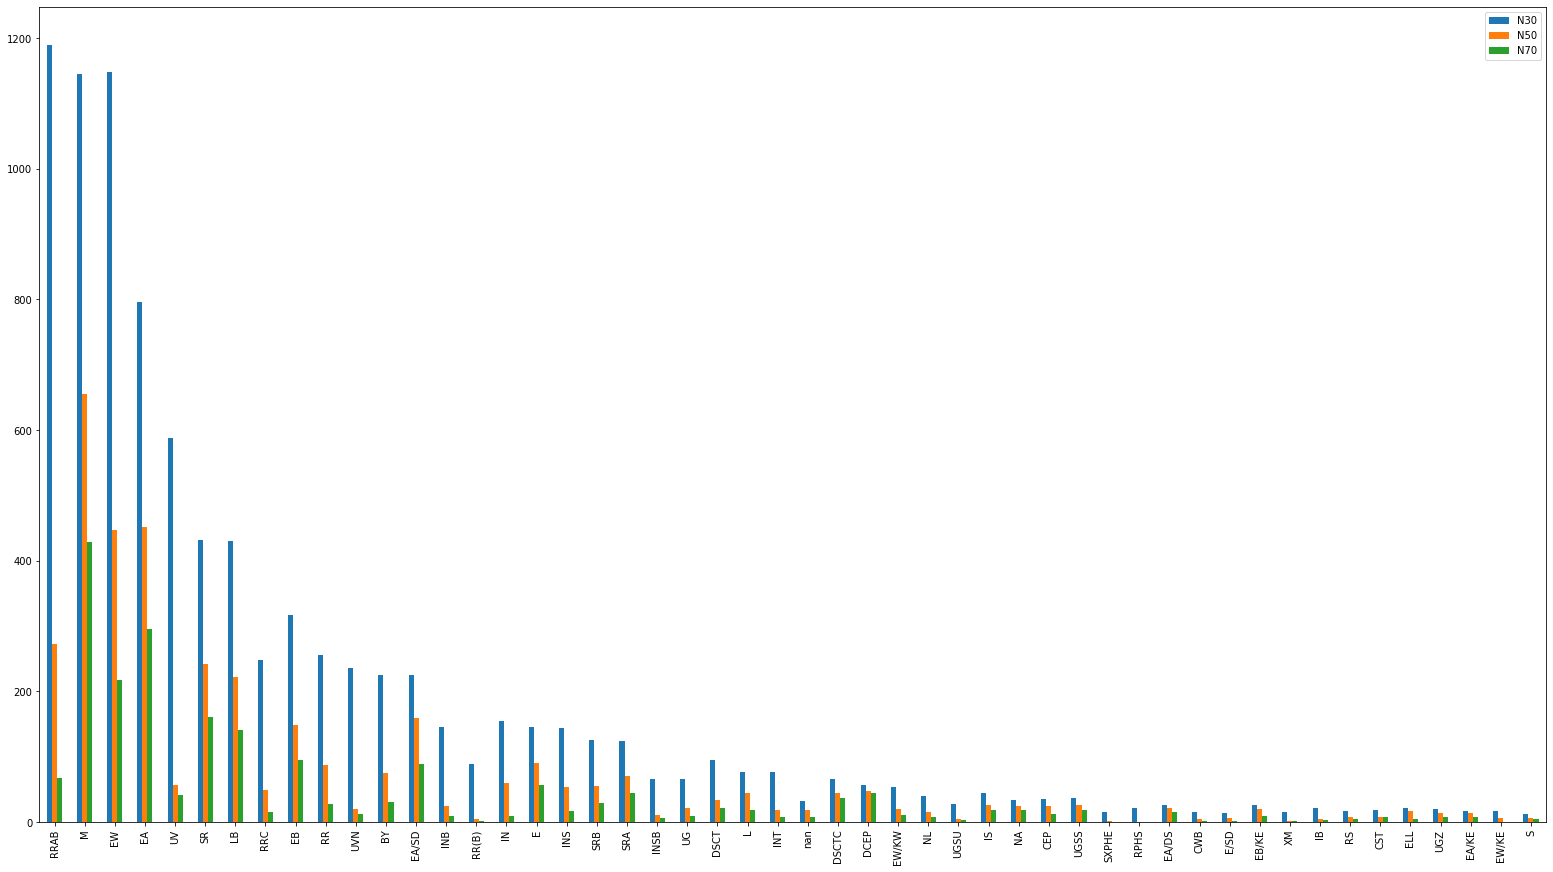

In [230]:
# dfff0=pd.DataFrame(list(zip(names,Nobs[Nobs['filter']=='zg']['Type'].value_counts().tolist(),df1[df1['filter']=='zr']['Type'].value_counts().tolist())),columns=['name','zg','zr'])
# dfff=df1['Type'].value_counts()[:100]
# dfff0.index=names
Nobs.plot(kind='bar',figsize=(27,15))

In [ ]:
Nobs[Nobs['Type']=='CEP']['N50'].tolist()[0]+Nobs[Nobs['Type']=='BCEP']['N50'].tolist()[0]+Nobs[Nobs['Type']=='DCEP']['N50'].tolist()[0]


In [249]:
df1

,ra,dec_x,Nobs,filter,Name,coord,Type,dec_y,Num
0,183.954,18.5393,33,zg,10016,121549.00 +183221.4,RR,18.539278,1
1,192.503,31.14,38,zg,10019,125000.62 +310824.0,RRAB,31.140000,1
2,199.532,28.8968,38,zg,10026,131807.71 +285348.6,RRAB,28.896833,1
3,184.695,23.6454,33,zg,10041,121846.69 +233843.1,M,23.645306,1
4,188.368,22.4778,35,zg,10050,123328.24 +222839.6,RRAB,22.477667,1
...,...,...,...,...,...,...,...,...,...
12994,36.116,-10.6764,33,zg,9647,022427.86 -104034.9,EA,-10.676361,4
12995,38.664,4.92455,29,zg,9648,023439.44 +045528.5,RRC,4.924583,1
12996,34.218,48.901,45,zg,97,021652.24 +485403.7,SR,48.901028,1
12997,79.211,-27.4735,10,zg,9962,051650.62 -272824.5,RRAB,-27.473472,1


In [ ]:
names=df1['Type'].value_counts()[:100].index.tolist()

In [ ]:
dfff0=pd.DataFrame(list(zip(names,df1[df1['filter']=='zg']['Type'].value_counts().tolist(),df1[df1['filter']=='zr']['Type'].value_counts().tolist())),columns=['name','zg','zr'])
# dfff=df1['Type'].value_counts()[:100]
dfff0.index=names
dfff0.plot(kind='bar',figsize=(20,10))

In [ ]:
k=0
list1=[]
df11=df1[df1['filter']=='zr']
for item in names:
    list1.append(df11[df11['Type']==item]['Nobs'].sum()/df11[df11['Type']==item].shape[0])
    k=k+1
t=0
list2=[]
df11=df1[df1['filter']=='zg']
for item in names:
    list2.append(df11[df11['Type']==item]['Nobs'].sum()/df11[df11['Type']==item].shape[0])
    t=t+1    

In [ ]:
obs=pd.DataFrame(list(zip(names,list1, list2)),columns=['Type','zg','zr'])
obs['Type']=names

for i in range(obs.shape[0]):
    obs['zg'][i]=int(obs['zg'][i])
    obs['zr'][i]=int(obs['zr'][i])
obs.index=obs['Type']    

In [ ]:
obs.plot(kind='bar',figsize=(20,10))

In [553]:
df11

,ra,dec_x,Nobs,filter,Name,coord_x,Type_x,coord_y,Type_y,GCVS,dec
0,184.946,16.51395,35,zg,10097,121947.01 +163050.3,EB,121947.01 +163050.3,EB,CN Com *,16.513972
1,185.859,16.08349,17,zg,10100,122326.20 +160500.5,RRAB,122326.20 +160500.5,RRAB,CR Com,16.083472
2,185.954,24.13216,16,zg,10102,122348.98 +240756.0,UV,122348.98 +240756.0,UV,CT Com *,24.132222
3,192.885,24.12269,19,zg,10136,125132.37 +240721.1,RRAB,125132.37 +240721.1,RRAB,EL Com *,24.122528
4,194.342,28.88876,39,zg,10139,125722.05 +285319.4,RRAB,125722.05 +285319.4,RRAB,EO Com *,28.888722
...,...,...,...,...,...,...,...,...,...,...,...
19943,12.512,-17.60746,30,zg,9545,005002.76 -173627.2,CWB,005002.76 -173627.2,CWB,BH Cet,-17.607556
19944,8.491,-13.52199,30,zg,9585,003357.77 -133119.1,RRAB,003357.77 -133119.1,RRAB,FV Cet,-13.521972
19945,22.885,-9.02282,30,zg,9599,013132.38 -090122.3,ZZ,013132.38 -090122.3,ZZ,GY Cet *,-9.022861
19946,38.344,0.84987,20,zg,9608,023322.59 +005100.3,NL,023322.59 +005100.3,NL,HP Cet,0.850083


In [248]:
names

['42755', '12512', '20581', '6970', '4634']

### Plot  curves for five random objects of type 'n'

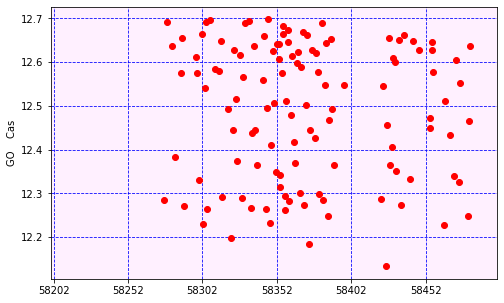

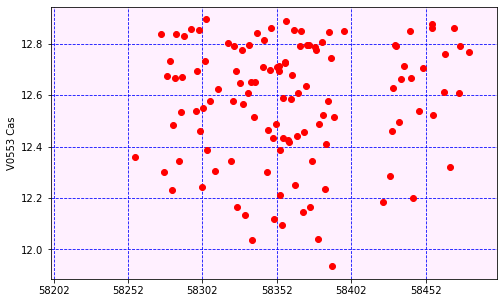

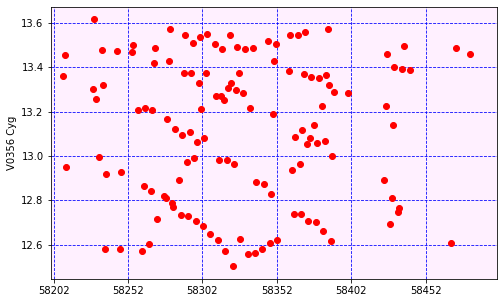

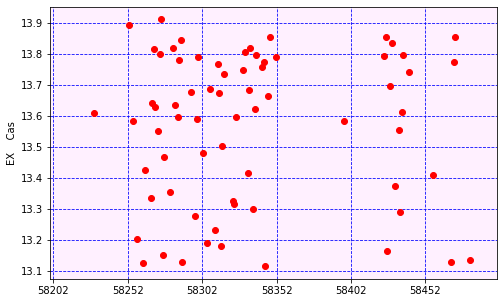

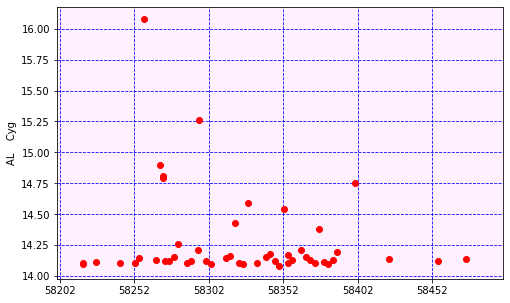

In [572]:
import random
from os import path
import matplotlib.backends.backend_pdf
import matplotlib.dates as mdates
outpath = "path/of/your/folder/"
# n=2
pdf = matplotlib.backends.backend_pdf.PdfPages(str(n)+".pdf")
names=random.sample(df11[df11['Type_y']=='DCEP']['Name'].tolist(), 5)
for item in names:
    with open(r"C:\Users\rtut6\Desktop\Backup\2\{}.txt".format(item)) as file:
        res = file.read().replace("'", '"')
        res=json.loads(res)
    x=[]
    y=[]
    for i in range(len(res[list(res.keys())[1]]['lc'])):
        x.append(res[list(res.keys())[1]]['lc'][i]['mjd'])
        y.append(res[list(res.keys())[1]]['lc'][i]['mag'])

        
#         days = mdates.drange(start,end,dt.timedelta(days=1))

    f=plt.figure(figsize=(8,5))
    plt.gca().set_xlim([58200,58500])
#     axes.set_ylim([ymin,ymax])
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=50))
    ax = plt.gca()
    ax.set_facecolor((1.0, 0.94, 1))
    plt.plot(x,y,'ro')
    
#     plt.gcf().autofmt_xdate()
    plt.ylabel(df11[df11['Name']==item]['GCVS'].tolist()[0])
    plt.grid(True,color='blue',linestyle="--")
    pdf.savefig(f) #saving pdf
    plt.show()
pdf.close()

In [573]:
from astroML.time_series import\
    lomb_scargle, lomb_scargle_BIC, lomb_scargle_bootstrap

In [571]:
# my_data = pd.DataFrame({'obj_id':[],
#                         'filter':[],
#                         'mean_magn':[],
#                         'amplitude':[],
#                         'trand_angle':[],
#                         'skew' : [],
#                         'std' : [],
#                         'max_PSD' : [],
#                         'max_fs' : [],
#                         'pointsN': [],
#                         'idN': [],
#                         'dist':[],
#                         'dist1':[],
#                         'dist2':[],                        
#                         'class':[]})

In [ ]:
with open(r"C:\Users\rtut6\Desktop\Backup\2\20048.txt".format(item)) as file: 
    res = file.read().replace("'", '"')
    res=json.loads(res)

In [ ]:
x=[]
y=[]
for i in range(len(res[list(res.keys())[1]]['lc'])):
    x.append(res[list(res.keys())[1]]['lc'][i]['mjd'])
    y.append(res[list(res.keys())[1]]['lc'][i]['mag'])

In [ ]:
plt.plot(x, y, 'ro')
plt.show()

In [ ]:
names

# Machine Learning 

In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split
# from xgboost import XGBClassifier
# from sklearn.metrics import average_precision_score
# from sklearn.metrics import mean_absolute_error
# from sklearn.metrics import roc_curve, auc,recall_score,precision_score
# from sklearn.metrics import accuracy_score

In [ ]:
# data1=df.drop(['filter','obj_id'], axis=1)

In [ ]:
# RandomForestClassifier

In [ ]:
# df1=df.iloc[1500:1725]
# array = data1.values
# X = array[:,0:7]
# Y = array[:,7]
# validation_size = 0.2
# seed = 5
# X_train=X[0:1500]
# X_validation=X[1500:1725]
# Y_train=Y[0:1500]
# Y_validation=Y[1500:1725]
# X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)
# X_train1, X_testt, Y_train1, Y_testt = train_test_split(X_train, Y_train, test_size=validation_size1, random_state=seed)
# print(Y)
# train.head()

In [ ]:
#Learning with XGB model
# model = XGBClassifier(random_state=34, seed=7, colsample_bytree=0.8, subsample=0.6, n_estimators=2000)
# model.fit(X_train,Y_train)
# pred = model.predict(X_validation)
# accuracy = accuracy_score(Y_validation, pred)
# print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [ ]:
# df1['pred']=pred
# df1.head(1000)

In [ ]:
# plt.figure(figsize=(10,5))
# plt.plot(np.array(obj_mjd1[9]), np.array(obj_mag1[9]))

In [ ]:
# obj_mag